<center><h1>VC01: Medidas de evaluación de algoritmos de agrupamiento</h1></center>

Tal y como se ha visto en la parte teórica de la asignatura, un agrupamiento se puede evaluar de manera intrínseca o extrínseca dependiendo de si está disponible o no la verdad básica (ground truth).

Para empezar, cargamos las librerías que vamos a necesitar:


In [1]:
import numpy as np
import pandas as pd
import itertools as it
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

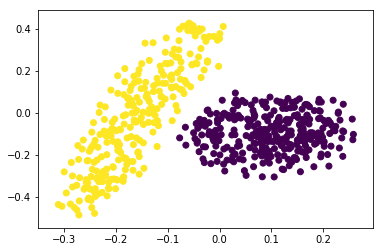

In [2]:
np.random.seed(19) # Fijamos una semilla para asegurar la reproducibilidad de la práctica

data_file_url = 'https://raw.githubusercontent.com/jhernandezgonzalez/unsupervisedlearning/master/datasets/sinteticos/dataset_dos_guassianas.csv'
D = np.array(pd.read_csv(data_file_url))
D = D[ np.random.choice(np.arange(D.shape[0]), D.shape[0], replace=False) ,:]
Dx = D[:,0:2]
Dy = D[:,2]

fig, ax = plt.subplots()
ax.scatter(Dx[:,0],Dx[:,1], c=Dy)



Realizamos un clustering de prueba que nos permitirá explorar el uso de las diferentes medidas de evaluación. En la siguiente sesión estudiaremos en detalle el algoritmo usado (Kmeans).


In [3]:
# Inicializar el método
agrup = KMeans(n_clusters=4)
# Aprender el agrupamiento
agrup = agrup.fit(Dx)
# Obtener la pertenencia de las instancias a los clústeres
Dyp = agrup.predict(Dx)
# Obtener los centroides de los clústeres
cDx = agrup.cluster_centers_


<h2>Medidas de evaluación extrínseca</h2>

Empezamos por obtener la matriz de confusión, que nos dice el número de coincidencias (intersección; número de ejemplos que aparecen en cierto clúster real y cierto clúster obtenido). Esta matriz nos permitirá construir las diferentes métricas de manera sencilla:


In [4]:
def matriz_confusion(cat_real, cat_pred):
    cats = np.unique(cat_real)
    clusts = np.unique(cat_pred)
    mat = np.array([[np.sum(np.logical_and(cat_real==cats[i], #### TU CODIGO AQUI ####
                                          )) 
                     for j in np.arange(clusts.size)] 
                    for i in np.arange(cats.size)])
    return(mat)

mC = matriz_confusion(Dy,Dyp)
print(mC)

[[  1 303   0  22]
 [ 84   0  91  92]]



Una vez obtenida la matriz de confusión, podemos definir diferentes métricas. Por ejemplo, el error, la precisión, el recall y la pureza se definen como...


In [5]:
def medida_error(mat):
    assign = np.sum([np.max(mat[l,:]) for l in np.arange(mat.shape[0])])
    return 1 - assign / float(np.sum(mat))

def medida_precision(mat, l, k):
    return mat[l,k]/#### TU CODIGO AQUI ####

def medida_recall(mat, l, k):
    return mat[l,k]/#### TU CODIGO AQUI ####

def medida_pureza(mat):
    totales = np.sum(mat,0)/float(np.sum(mat))
    return np.sum([#### TU CODIGO AQUI ####
                   * np.max(mat[:,k]/float(np.sum(mat[:,k]))) for k in np.arange(mat.shape[1])])

print('El valor del error cometido es = ', medida_error(mC))
print('La pureza del agrupamiento obtenido es = ', medida_pureza(mC))

El valor del error cometido es =  0.33389544688026984
La pureza del agrupamiento obtenido es =  0.9612141652613828



Por su parte, la medida F1 es una combinación de la precisión y el recall:


In [6]:
def medida_f1_especifica(mat, l, k):
    prec = medida_precision(mat, l, k)
    rec = medida_recall(mat, l, k)
    if (prec+rec)==0:
        return 0
    else:
        return #### TU CODIGO AQUI ####

def medida_f1(mat):
    totales = np.sum(mat,1)/float(np.sum(mat))
    assign = np.sum([totales[l] * np.max([medida_f1_especifica(mat, l, k) 
                                          for k in np.arange(mat.shape[1])]) 
                     for l in np.arange(mat.shape[0])])
    return assign

print('El valor F1 es = ', medida_f1(mC))

El valor F1 es =  0.7585445555203366



La entropía es una medida que expresa el grado de (des)organización:


In [7]:
def medida_entropia(mat):
    totales = np.sum(mat,0)/float(np.sum(mat))
    relMat = mat/np.sum(mat,0)
    logRelMat = relMat.copy()
    logRelMat[logRelMat==0]=0.0001 # Evita el logaritmo de 0. Inofensivo pues luego desaparece al multiplicar por 0
    logRelMat = #### TU CODIGO AQUI ####
    return -np.sum([totales[k] * np.sum([relMat[l,k]*logRelMat[l,k] 
                                         for l in np.arange(mat.shape[0])]) 
                    for k in np.arange(mat.shape[1])])
  
print('La entropía es = ', medida_entropia(mC))

La entropía es =  0.10346692369884718



Y la información mutua expresa cómo una variable (agrupamiento) puede explicar otra:


In [8]:
def medida_informacion_mutua(mat):
    relMat = mat/float(np.sum(mat))
    logRelMat = mat.copy()
    logRelMat = logRelMat/np.sum(mat,0,keepdims=True)
    logRelMat = logRelMat/np.sum(mat,1,keepdims=True)
    logRelMat[logRelMat==0]=0.000001 # Evita el logaritmo de 0. Inofensivo pues luego desaparece al multiplicar por 0
    logRelMat = #### TU CODIGO AQUI ####
    return np.sum([np.sum([relMat[l,k]*logRelMat[l,k]
                           for l in np.arange(mat.shape[0])])
                   for k in np.arange(mat.shape[1])])
  
print('La información mutua es = ', medida_informacion_mutua(mC), "(** ESTE ES EL VALOR A INTRODUCIR EN EL CAMPUS**)")

La información mutua es =  0.5847225206303903 (** ESTE ES EL VALOR A INTRODUCIR EN EL CAMPUS**)


<hr>
<h2>Medidas de evaluación intrínseca</h2>

En este caso se asume que no se conoce el agrupamiento real. Entonces, sólo es posible realizar la evaluación en base a las características del agrupamiento devuelto.

En el caso de la medida RMSSTD, tenemos que:


In [9]:
def medida_RMSSTD(X, Xyp, cXs):
    labels = np.unique(Xyp)
    num = np.sum([ np.sum(np.sum(X[Xyp==labels[k],:]-cXs[labels[k],:],1)**2) for k in np.arange(labels.size)])
    den = X.shape[1] * np.sum([np.sum(Xyp==labels[k])-1 for k in np.arange(labels.size)])

    return #### TU CODIGO AQUI ####

print('El error RMSSTD es = ',medida_RMSSTD(Dx, Dyp, cDx))

El error RMSSTD es =  0.0816509522611048



La medida R cuadrado se puede escribir como:


In [10]:
def medida_R_cuadrado(X, Xyp, cXs):
    cXglob = np.mean(X,axis=0) 
    labels = np.sort(np.unique(Xyp))
    sumTotal = np.sum(np.sum(X-cXglob,1)**2) 
    interior = np.sum([ np.sum(np.sum(X[Xyp==labels[k],:]-cXs[labels[k],:],1)**2) for k in np.arange(labels.size)])
    
    return #### TU CODIGO AQUI ####

print('El valor de la medida R cuadrado es = ', medida_R_cuadrado(Dx, Dyp, cDx))

El valor de la medida R cuadrado es =  0.7760764406927991



La medida de ancho de silueta es...


In [11]:
def distancia_euclidiana(x, y):   
    return np.sqrt(np.sum((x - y) ** 2))

def matriz_distancias(X, distancia):
    mD = np.zeros((X.shape[0],X.shape[0]))
    for pair in it.product(np.arange(X.shape[0]), repeat=2):
        mD[pair] = distancia(X[pair[0],:],X[pair[1],:])
    return mD

def calcular_matriz_a(X, Xyp, mD):
    labels = np.sort(np.unique(Xyp))
    factores = 1.0/(np.array([np.sum(Xyp==labels[k]) for k in np.arange(labels.size)])-1)
    aX = np.zeros(X.shape[0])
    for i in np.arange(X.shape[0]):
        k = Xyp[i]
        aX[i] = factores[k] * np.sum([mD[i,ip] 
                                      for ip in np.arange(X.shape[0])[Xyp==labels[k]]])
    return(aX)

def calcular_matriz_b(X, Xyp, mD):
    labels = np.sort(np.unique(Xyp))
    factores = 1.0/np.array([np.sum(Xyp==labels[k]) for k in np.arange(labels.size)])
    bX = np.zeros(X.shape[0])
    for i in np.arange(X.shape[0]):
        k = Xyp[i]
        ran = np.arange(labels.size)
        ran = ran[np.arange(labels.size)!=k]
        res = np.array([factores[h] * np.sum([mD[i,ip]
                                              for ip in np.arange(X.shape[0])[Xyp==labels[h]]])
                        for h in ran])
        bX[i] = np.min(res)
    return(bX)

def medida_silueta(X, Xyp, distancia):
    mD = matriz_distancias(X, distancia)
    labels = np.sort(np.unique(Xyp))
    factores = 1.0/np.array([np.sum(Xyp==labels[k]) for k in np.arange(labels.size)])

    A = calcular_matriz_a(X, Xyp, mD)
    B = calcular_matriz_b(X, Xyp, mD)
    impl = #### TU CODIGO AQUI ####/np.maximum(A,B)
    
    res = np.sum([factores[k] * np.sum(impl[Xyp==labels[k]]) 
                  for k in np.arange(labels.size)])/labels.size

    return np.mean(impl)

print('El valor de la medida Silueta es = ', medida_silueta(Dx, Dyp, distancia_euclidiana))

El valor de la medida Silueta es =  0.4767301998952725



La medida Calinksi-Harabasz es ...


In [12]:
def medida_calinski_harabasz(X, Xyp, cXs, distancia):
    cXglob = np.mean(X,axis=0) 
    labels = np.sort(np.unique(Xyp))
    factores = np.array([np.sum(Xyp==labels[k]) for k in np.arange(labels.size)])

    num = (X.shape[0]-labels.size)*np.sum([factores[k]*distancia(cXs[k,:],cXglob)**2 
                                           for k in np.arange(cXs.shape[0])])
    den = (labels.size-1)*np.sum([np.sum([distancia(X[i,:],cXs[k,:])**2 
                                            for i in np.arange(X.shape[0])[Xyp==labels[k]]])
                                           for k in np.arange(cXs.shape[0])])
    return num/den
print('El valor de la medida Calinski-Harabasz es = ', medida_calinski_harabasz(Dx, Dyp, cDx, distancia_euclidiana))

El valor de la medida Calinski-Harabasz es =  734.4386259522338



La medida I es...


In [13]:
def medida_I(X, Xyp, cXs, distancia):
    cXglob = np.mean(X, axis = 0) 
    labels = np.sort(np.unique(Xyp))
    maxDcs = np.max(matriz_distancias(cXs, distancia))

    num = np.sum([distancia(X[i,:], cXglob) for i in np.arange(X.shape[0])])

    den = labels.size * np.sum([np.sum([distancia(X[i,:], cXs[k,:])
                                        for i in np.arange(X.shape[0])[Xyp==labels[k]]])
                                for k in np.arange(cXs.shape[0])])
    return #### TU CODIGO AQUI ####

print('El valor de la medida I es = ', medida_I(Dx, Dyp, cDx, distancia_euclidiana))

El valor de la medida I es =  0.09488067392893718



La medida Davies-Bouldin es...


In [14]:
def medida_davies_bouldin(X, Xyp, cXs, distancia):
    labels = np.sort(np.unique(Xyp))
    mDcs = matriz_distancias(cXs, distancia)
    np.fill_diagonal(mDcs, np.Infinity)

    vals = np.array([1.0 / np.sum(Xyp==labels[k]) * np.sum([distancia(X[i,:], cXs[k,:])
                                                            for i in np.arange(X.shape[0])[Xyp==labels[k]]])
                     for k in np.arange(cXs.shape[0])])
    res = 1.0/labels.size*np.sum([np.max([(vals[k]+vals[kp])/mDcs[k,kp] 
                                          for kp in np.arange(labels.size)])
                                  for k in np.arange(labels.size)])
    return res
print('El valor de la medida Davies-Bouldin es = ', medida_davies_bouldin(Dx, Dyp, cDx, distancia_euclidiana))

El valor de la medida Davies-Bouldin es =  0.6896889690784486


<hr>
<h2>Implementaciones en librerías de Python</h2>

La mayoría de estas medidas ya están programadas en librerías de Python. Aquí tenemos unos ejemplos. Los comparamos con las que hemos programado para asegurarnos de que devuelven los mismos valores:


In [15]:
from sklearn.metrics import mutual_info_score, silhouette_score, davies_bouldin_score, calinski_harabaz_score

print(np.round(np.abs(mutual_info_score(Dy, Dyp)-
                      medida_informacion_mutua(mC)),10))
print(np.round(np.abs(silhouette_score(Dx,Dyp)-
                      medida_silueta(Dx, Dyp, distancia_euclidiana)),10))
print(np.round(np.abs(calinski_harabaz_score(Dx, Dyp)-
                      medida_calinski_harabasz(Dx, Dyp, cDx, distancia_euclidiana)),10))
print(np.round(np.abs(davies_bouldin_score(Dx, Dyp)-
                      medida_davies_bouldin(Dx, Dyp, cDx, distancia_euclidiana)),10))

0.0
0.0
0.0
0.0


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
